# Exploratory Data Analysis (EDA)

## Data description :

The dataset used in this project is a corpus of scientific abstract associated with a human supervized label describing whether the abstract is relevant or not.

## Data loading

Here we load the data files (that are scattered in different directories), into one dataset for positives and negatives.

We also consider only instances that have a doi value (we reject None values)

The other we do is that we extract positives and negatives from the corpus with the help of the given positive data.

In [ ]:
from data.create_ipbes_raw import *

pos_ds, neg_ds, corpus_ds=loading_pipeline_from_raw()
print("corpus columns :",corpus_ds.features)
print("positives columns :",pos_ds[0].features)
print("negatives columns :",neg_ds[0].features)

print("corpus size :",len(corpus_ds))
print("positives size :",len(pos_ds[0]))
print("negatives size :",len(neg_ds[0]))

pos_raw=get_ipbes_positives()



/home/leandre/Projects/BioMoQA_Playground/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


128
Successfully loaded dataset from: /home/leandre/Projects/BioMoQA_Playground/data/corpus/Raw/Positives/IPBES IAS_2352922
86
Successfully loaded dataset from: /home/leandre/Projects/BioMoQA_Playground/data/corpus/Raw/Positives/IPBES SUA_2344805
128
Successfully loaded dataset from: /home/leandre/Projects/BioMoQA_Playground/data/corpus/Raw/Positives/IPBES VA_2345372
{'DOI': Value(dtype='string', id=None), 'Title': Value(dtype='string', id=None), 'Abstract Note': Value(dtype='string', id=None), 'Language': Value(dtype='string', id=None)}
creating corpus dataset
dataset loaded
['id', 'display_name', 'author', 'ab', 'doi', 'topics', 'author_abbr']
1


Filter (num_proc=32): 100%|██████████| 4227131/4227131 [00:32<00:00, 131807.85 examples/s]


2
Finished positives and negatives creation pipeline
corpus columns : {'id': Value(dtype='string', id=None), 'display_name': Value(dtype='string', id=None), 'author': [{'au_id': Value(dtype='string', id=None), 'au_display_name': Value(dtype='string', id=None), 'au_orcid': Value(dtype='string', id=None), 'author_position': Value(dtype='string', id=None), 'is_corresponding': Value(dtype='bool', id=None), 'au_affiliation_raw': Value(dtype='string', id=None), 'institution_id': Value(dtype='string', id=None), 'institution_display_name': Value(dtype='string', id=None), 'institution_ror': Value(dtype='string', id=None), 'institution_country_code': Value(dtype='string', id=None), 'institution_type': Value(dtype='string', id=None), 'institution_lineage': Value(dtype='string', id=None)}], 'ab': Value(dtype='string', id=None), 'doi': Value(dtype='string', id=None), 'topics': [{'i': Value(dtype='int32', id=None), 'score': Value(dtype='float64', id=None), 'name': Value(dtype='string', id=None), 'id

In [2]:
print(pos_ds)
print(neg_ds)

[Dataset({
    features: ['doi', 'title', 'abstract'],
    num_rows: 5251
}), Dataset({
    features: ['doi', 'title', 'abstract'],
    num_rows: 6281
}), Dataset({
    features: ['doi', 'title', 'abstract'],
    num_rows: 3109
})]
[Dataset({
    features: ['title', 'abstract', 'doi'],
    num_rows: 4190054
}), Dataset({
    features: ['title', 'abstract', 'doi'],
    num_rows: 4190005
}), Dataset({
    features: ['title', 'abstract', 'doi'],
    num_rows: 4185398
})]


In [21]:
print(corpus_ds.column_names)
print(corpus_ds[0])

['id', 'display_name', 'author', 'ab', 'doi', 'topics', 'author_abbr']
{'id': 'https://openalex.org/W1979751022', 'display_name': 'Observations on an apparatus to illustrate the composition and resolution forces, and to measure the power obtained by certain parts of machinery operating on this principle', 'author': [{'au_id': 'https://openalex.org/A5055018967', 'au_display_name': 'W. R. Johnson', 'au_orcid': None, 'author_position': 'first', 'is_corresponding': True, 'au_affiliation_raw': '', 'institution_id': None, 'institution_display_name': None, 'institution_ror': None, 'institution_country_code': None, 'institution_type': None, 'institution_lineage': None}], 'ab': "Physical components of societies like infrastructures need biophysical resources for their construction, maintenance and use. These components, analyzed as societies' material stocks, predefine energy and raw materials and provide societal services, necessary for their functioning and for social welfare. The nexus betwe

In [26]:
print(len(pos_raw[0]["Abstract Note"]))
new_pos_raw=pos_raw[0].filter(lambda x: x["Abstract Note"] != None)
print(len(new_pos_raw))


5251
2657


In [30]:
print(corpus_ds)
print(pos_ds)

corpus_pos_ds=[]
for i in range(len(pos_ds)):
    print(i)
    abs_set=set(e.strip() for e in pos_ds[i]['abstract'] if e is not None)
    titles_set=set(e.strip() for e in pos_ds[i]['title'] if e is not None)
    dois_set=set(e.strip() for e in pos_ds[i]['doi'] if e is not None)
    if None in dois_set : dois_set.remove(None) 
    if None in titles_set : titles_set.remove(None) 
    if None in abs_set : abs_set.remove(None) 
    print("titles_set size :",len(titles_set))
    print("abs_set size :",len(abs_set))
    print("dois_set size :",len(dois_set))

    seen_abstracts=set()
    seen_titles=set()
    seen_dois=set()
    def find(batch):
        batch_bools=[]
        for j in range(len(batch['display_name'])):
            title=batch['display_name'][j]
            title=title.strip() if title is not None else None
            abstract=batch['ab'][j]
            abstract=abstract.strip() if abstract is not None else None
            doi=batch['doi'][j]
            doi=doi.strip() if doi is not None else None
            
            if (abstract in abs_set) and (abstract not in seen_abstracts):
                seen_abstracts.add(abstract)
                batch_bools.append(True)
            elif (title in titles_set) and (title not in seen_titles):
                seen_titles.add(title)
                batch_bools.append(True)
            elif (doi is not None) and(any(doi.endswith(p_doi) for p_doi in dois_set)) and (doi not in seen_dois):
                batch_bools.append(True)
                seen_dois.add(doi)
            else:
                batch_bools.append(False)
        return batch_bools
    temp_ds=corpus_ds.filter(find, batched=True, batch_size=1000,num_proc=32)
    corpus_pos_ds.append(temp_ds)
    print(temp_ds)



Dataset({
    features: ['id', 'display_name', 'author', 'ab', 'doi', 'topics', 'author_abbr'],
    num_rows: 4227131
})
[Dataset({
    features: ['doi', 'title', 'abstract', 'Language'],
    num_rows: 5251
}), Dataset({
    features: ['doi', 'title', 'abstract', 'Language'],
    num_rows: 6281
}), Dataset({
    features: ['doi', 'title', 'abstract', 'Language'],
    num_rows: 3109
})]
0
titles_set size : 5228
abs_set size : 2653
dois_set size : 3861


Filter (num_proc=32): 100%|██████████| 4227131/4227131 [01:02<00:00, 67720.70 examples/s]


Dataset({
    features: ['id', 'display_name', 'author', 'ab', 'doi', 'topics', 'author_abbr'],
    num_rows: 1161
})
1
titles_set size : 6169
abs_set size : 1368
dois_set size : 2919


Filter (num_proc=32): 100%|██████████| 4227131/4227131 [00:48<00:00, 86788.27 examples/s] 


Dataset({
    features: ['id', 'display_name', 'author', 'ab', 'doi', 'topics', 'author_abbr'],
    num_rows: 1191
})
2
titles_set size : 2945
abs_set size : 2069
dois_set size : 1892


Filter (num_proc=32): 100%|██████████| 4227131/4227131 [00:32<00:00, 131456.24 examples/s]


Dataset({
    features: ['id', 'display_name', 'author', 'ab', 'doi', 'topics', 'author_abbr'],
    num_rows: 723
})


In [ ]:
def is_weird(batch):
    batch_bools=[]
    for j in range(len(batch['title'])):
        title=batch['title'][j]
        abstract=batch['abstract'][j]
        doi=batch['doi'][j]
        if doi =='DOI':
            batch_bools.append(True)
        elif title == 'Title':
            batch_bools.append(True)
        elif abstract == 'Abstract Note':
            batch_bools.append(True)
        else:
            batch_bools.append(False)
    return batch_bools

weird_pos=pos_ds[0].filter(is_weird, batched=True, batch_size=1000,num_proc=32)
print(weird_pos)

Filter (num_proc=32): 100%|██████████| 5251/5251 [00:00<00:00, 19313.10 examples/s]

Dataset({
    features: ['doi', 'title', 'abstract'],
    num_rows: 0
})


In [ ]:
# Convert corpus_ds to a set for faster lookups
abstract_set = set(corpus_ds['ab'])
title_set = set(corpus_ds['display_name'])

# Check for matches based on Abstract
abstract_matches = []
for pos_dataset in pos_raw:
    matches = pos_dataset.filter(lambda x: x['Abstract Note'] in abstract_set)
    abstract_matches.append(matches)

# Check for matches based on Title
title_matches = []
for pos_dataset in pos_raw:
    matches = pos_dataset.filter(lambda x: x['Title'] in title_set)
    title_matches.append(matches)

# Print results
print("Matches based on abstract:")
for i, match in enumerate(abstract_matches):
    print(f"Dataset {i}: {len(match)} matches")

print("\nMatches based on Title:")
for i, match in enumerate(title_matches):
    print(f"Dataset {i}: {len(match)} matches")

NameError: name 'corpus_ds' is not defined

In [ ]:

print(pos_raw)
print("positives raw size :",[len(pos_raw[i]) for i in range(len(pos_raw))])
print("positives raw columns :",[pos_raw[i].features for i in range(len(pos_raw))])

Generating train split: 0 examples [00:00, ? examples/s]


Error loading files from /home/leandre/Projects/BioMoQA_Playground/data/corpus/Raw/Positives/IPBES IAS_2352922: An error occurred while generating the dataset


Generating train split: 0 examples [00:00, ? examples/s]


Error loading files from /home/leandre/Projects/BioMoQA_Playground/data/corpus/Raw/Positives/IPBES SUA_2344805: An error occurred while generating the dataset


Generating train split: 0 examples [00:00, ? examples/s]

Error loading files from /home/leandre/Projects/BioMoQA_Playground/data/corpus/Raw/Positives/IPBES VA_2345372: An error occurred while generating the dataset
[]
positives raw size : []
positives raw columns : []


## Data pre-processing

Now that we have loaded the data we are able to clean them and pre-process them in order to give them to the model.

In particular what we want to do is :
- Reject abstracts with None values
- Manage duplicates
- Manage conflicts (cases wher you have an isntance in both positives and negatives)
- Consider only journal articles

In [2]:
import os 
import sys

parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from data import loading_pipeline_from_raw

pos_ds,neg_ds,corpus_ds=loading_pipeline_from_raw()

/home/leandre/Projects/BioMoQA_Playground/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


128
Successfully loaded dataset from: /home/leandre/Projects/BioMoQA_Playground/data/corpus/Raw/Positives/IPBES IAS_2352922
86
Successfully loaded dataset from: /home/leandre/Projects/BioMoQA_Playground/data/corpus/Raw/Positives/IPBES SUA_2344805
128
Successfully loaded dataset from: /home/leandre/Projects/BioMoQA_Playground/data/corpus/Raw/Positives/IPBES VA_2345372
pos_ds features for IAS :  {'Key': Value(dtype='string', id=None), 'DOI': Value(dtype='string', id=None), 'Title': Value(dtype='string', id=None), 'Abstract Note': Value(dtype='string', id=None), 'Language': Value(dtype='string', id=None), 'ISBN': Value(dtype='string', id=None), 'ISSN': Value(dtype='string', id=None), 'Url': Value(dtype='string', id=None)}
creating corpus dataset
dataset loaded
['id', 'display_name', 'author', 'ab', 'doi', 'topics', 'author_abbr']
1
2
Finished positives and negatives creation pipeline


In [4]:
print(pos_ds[0]["ISBN"])
print(pos_ds[0]["ISSN"])
print(len(pos_ds[0]))
clean_pos=pos_ds[0].filter(lambda x: (x["Abstract Note"]!=None) and (x["Title"]!=None) )
print(len(clean_pos))

print(len([e for e in clean_pos if (e["ISBN"]==None) and (e["ISSN"]==None) and (e["DOI"]==None)  and (e["Url"]==None)]))
print(len([e for e in clean_pos["Url"] if (e==None)]))

print("Filtering...")

abs_set=set(e.strip() for e in clean_pos['Abstract Note'] if e is not None)
titles_set=set(e.strip() for e in clean_pos['Title'] if e is not None)
dois_set=set(e.strip() for e in clean_pos['DOI'] if e is not None)
if None in dois_set : dois_set.remove(None) 
if None in titles_set : titles_set.remove(None) 
if None in abs_set : abs_set.remove(None) 

def find(batch):
    batch_bools=[]
    for j in range(len(batch['display_name'])):
        title=batch['display_name'][j]
        title=title.strip() if title is not None else None
        abstract=batch['ab'][j]
        abstract=abstract.strip() if abstract is not None else None
        doi=batch['doi'][j]
        doi=doi.strip() if doi is not None else None
        
        if abstract is not None and (abstract in abs_set):
            batch_bools.append(True)
        elif title is not None and (title in titles_set):
            batch_bools.append(True)
        elif (doi is not None) and (any(doi.endswith(p_doi) for p_doi in dois_set)):
            batch_bools.append(True)
        else:
            batch_bools.append(False)
    return batch_bools
corp_in_pos=corpus_ds.filter(find, batched=True,batch_size=1000,num_proc=32)
print("corp_in_pos size :",len(corp_in_pos))

[None, None, '978-0-226-47021-4', None, None, None, None, None, None, None, None, None, None, None, None, '978-1-4020-8280-1', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, '978-0-520-26421-2', None, None, None, None, None, None, None, '978-1-84971-228-6', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, '0-9932203-4-7 / 978-0-9932203-4-0', None, None, None, None, None, '978-0-12-821575-3', None, None, '978-1-119-07580-6 978-1-119-07577-6', None, None, '978-3-540-77375-7 978-3-540-36920-2', None, None, '978-92-4-150853-7', None, None, None, '978-0-226-206

Filter (num_proc=32): 100%|██████████| 4227131/4227131 [00:53<00:00, 78881.12 examples/s] 


corp_in_pos size : 711


## Here we test the unifed data and classic data pipeline functions :

In [1]:
import os 
import sys

parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Adjust ".." based on your structure

# Add it to sys.path
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from data import data_pipeline

data_dict=data_pipeline(multi_label=False)
unified_data=data_pipeline(multi_label=True)

print("Data dict for binary classification : ",data_dict)
print("Unified data :",unified_data)

/home/leandre/Projects/BioMoQA_Playground/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/leandre/Projects/BioMoQA_Playground/data/corpus/Raw/Positives/IPBES IAS_2352922
128
Successfully loaded dataset from: /home/leandre/Projects/BioMoQA_Playground/data/corpus/Raw/Positives/IPBES IAS_2352922
/home/leandre/Projects/BioMoQA_Playground/data/corpus/Raw/Positives/IPBES SUA_2344805
86
Successfully loaded dataset from: /home/leandre/Projects/BioMoQA_Playground/data/corpus/Raw/Positives/IPBES SUA_2344805
/home/leandre/Projects/BioMoQA_Playground/data/corpus/Raw/Positives/IPBES VA_2345372
128
Successfully loaded dataset from: /home/leandre/Projects/BioMoQA_Playground/data/corpus/Raw/Positives/IPBES VA_2345372
pos_ds features for IAS :  {'DOI': Value(dtype='string', id=None), 'Title': Value(dtype='string', id=None), 'Abstract Note': Value(dtype='string', id=None), 'Language': Value(dtype='string', id=None)}
creating corpus dataset
dataset loaded
['id', 'display_name', 'author', 'ab', 'doi', 'topics', 'author_abbr']
1
2
Finished positives and negatives creation pipeline
Process

Map (num_proc=32): 100%|██████████| 4197487/4197487 [00:27<00:00, 150683.62 examples/s]


Data dict for binary classification :  {'IAS': Dataset({
    features: ['doi', 'title', 'abstract', 'labels'],
    num_rows: 4114546
}), 'SUA': Dataset({
    features: ['doi', 'title', 'abstract', 'labels'],
    num_rows: 4113318
}), 'VA': Dataset({
    features: ['doi', 'title', 'abstract', 'labels'],
    num_rows: 4109595
})}
Unified data : Dataset({
    features: ['doi', 'title', 'abstract', '__index_level_0__', 'IAS', 'SUA', 'VA'],
    num_rows: 4197487
})


## We check that the unified data is correctly build

In [2]:
print(data_dict)
titles_sets_dict={data_type:set(data_dict[data_type]["title"])for data_type in data_dict}

{'IAS': Dataset({
    features: ['doi', 'title', 'abstract', 'labels'],
    num_rows: 4114546
}), 'SUA': Dataset({
    features: ['doi', 'title', 'abstract', 'labels'],
    num_rows: 4113318
}), 'VA': Dataset({
    features: ['doi', 'title', 'abstract', 'labels'],
    num_rows: 4109595
})}


In [3]:
def is_label(batch,label):
    batch_bools=[]
    for x in batch[label]:
        if x==1:
            batch_bools.append(True)
        else:
            batch_bools.append(False)
        
    return batch_bools

ias_pos_from_unified=unified_data.filter(lambda batch : is_label(batch,"IAS"),batched=True,batch_size=1000,num_proc=os.cpu_count())
sua_pos_from_unified=unified_data.filter(lambda batch : is_label(batch,"SUA"),batched=True,batch_size=1000,num_proc=os.cpu_count())
va_pos_from_unified=unified_data.filter(lambda batch : is_label(batch,"VA"),batched=True,batch_size=1000,num_proc=os.cpu_count())

print(ias_pos_from_unified)
print(sua_pos_from_unified)
print(va_pos_from_unified)

Filter (num_proc=32): 100%|██████████| 4197487/4197487 [00:00<00:00, 5263910.00 examples/s]


Dataset({
    features: ['doi', 'title', 'abstract', '__index_level_0__', 'IAS', 'SUA', 'VA'],
    num_rows: 10976
})
Dataset({
    features: ['doi', 'title', 'abstract', '__index_level_0__', 'IAS', 'SUA', 'VA'],
    num_rows: 9698
})
Dataset({
    features: ['doi', 'title', 'abstract', '__index_level_0__', 'IAS', 'SUA', 'VA'],
    num_rows: 10396
})


## We check the overlaps betweens labels with respect to the doi, title and abstract. We hence look for super positive

In [ ]:
ias_data=data_dict["IAS"]
sua_data=data_dict["SUA"]
va_data=data_dict["VA"]

ias_positives = ias_data.filter(lambda x: x['labels'] == 1,batch_size=1000,num_proc=32)
sua_positives = sua_data.filter(lambda x: x['labels'] == 1,batch_size=1000,num_proc=32)
va_positives = va_data.filter(lambda x: x['labels'] == 1,batch_size=1000,num_proc=32)

multiple_dataset_instances_list=set()
super_pos_list=set()
for tag in ['doi','title','abstract']:
    print(tag)
    # Find instances present in more than one dataset
    ias_set = set(ias_positives[tag])
    sua_set = set(sua_positives[tag])
    va_set = set(va_positives[tag])

    # Find overlaps
    ias_sua_overlap = ias_set.intersection(sua_set)
    ias_va_overlap = ias_set.intersection(va_set)
    sua_va_overlap = sua_set.intersection(va_set)
    all_three=ias_set.intersection(sua_set).intersection(va_set)
    #TODO: This is an error, we should add the same column every time
    super_pos_list=super_pos_list.union(all_three)
    # Find instances in more than one dataset
    multiple_dataset_instances = ias_sua_overlap.union(ias_va_overlap).union(sua_va_overlap)
    multiple_dataset_instances_list=multiple_dataset_instances_list.union(multiple_dataset_instances)
    # Print results
    print(f"Number of instances in more than one dataset: {len(multiple_dataset_instances)}")
    print("Sample instances:", list(multiple_dataset_instances)[:10])

    print("Number of Super positives : ", len(all_three))
    print("Super positives instances : ",list(all_three))

print("Total Multi-positives :",len(multiple_dataset_instances_list))
print("Total Super-Positives : ",len(super_pos_list))

doi
Number of instances in more than one dataset: 36
Sample instances: ['10.1098/rsbl.2015.0623', '10.1017/S095927090800035X', '10.1016/j.cosust.2014.11.002', '10.5751/ES-09448-220324', '10.1080/01944366908977225', 'http://dx.doi.org/10.1016/j.ijrobp.2010.07.1349', '10.1371/journal.pbio.1002040', '10.3390/w13030265', '10.1111/1745-5871.12267', '10.5751/ES-06824-190356']
Number of Super positives :  3
Super positives instances :  ['10.1016/j.cosust.2014.11.002', None, '10.1126/science.aal1950']
title
Number of instances in more than one dataset: 40
Sample instances: ["Assessing nature's contributions to people", 'Global Land Outlook', 'A decade of adaptive governance scholarship: synthesis and future directions', 'Holding up a mirror to the society: Children recognize exotic species much more than local ones', 'The dispersal of alien species redefines biogeography in the Anthropocene', 'Sustainability Science: Toward a Synthesis', 'Governance of Ecosystem Services: A framework for empir

## Plot of the metrics, based on the csv metrics file

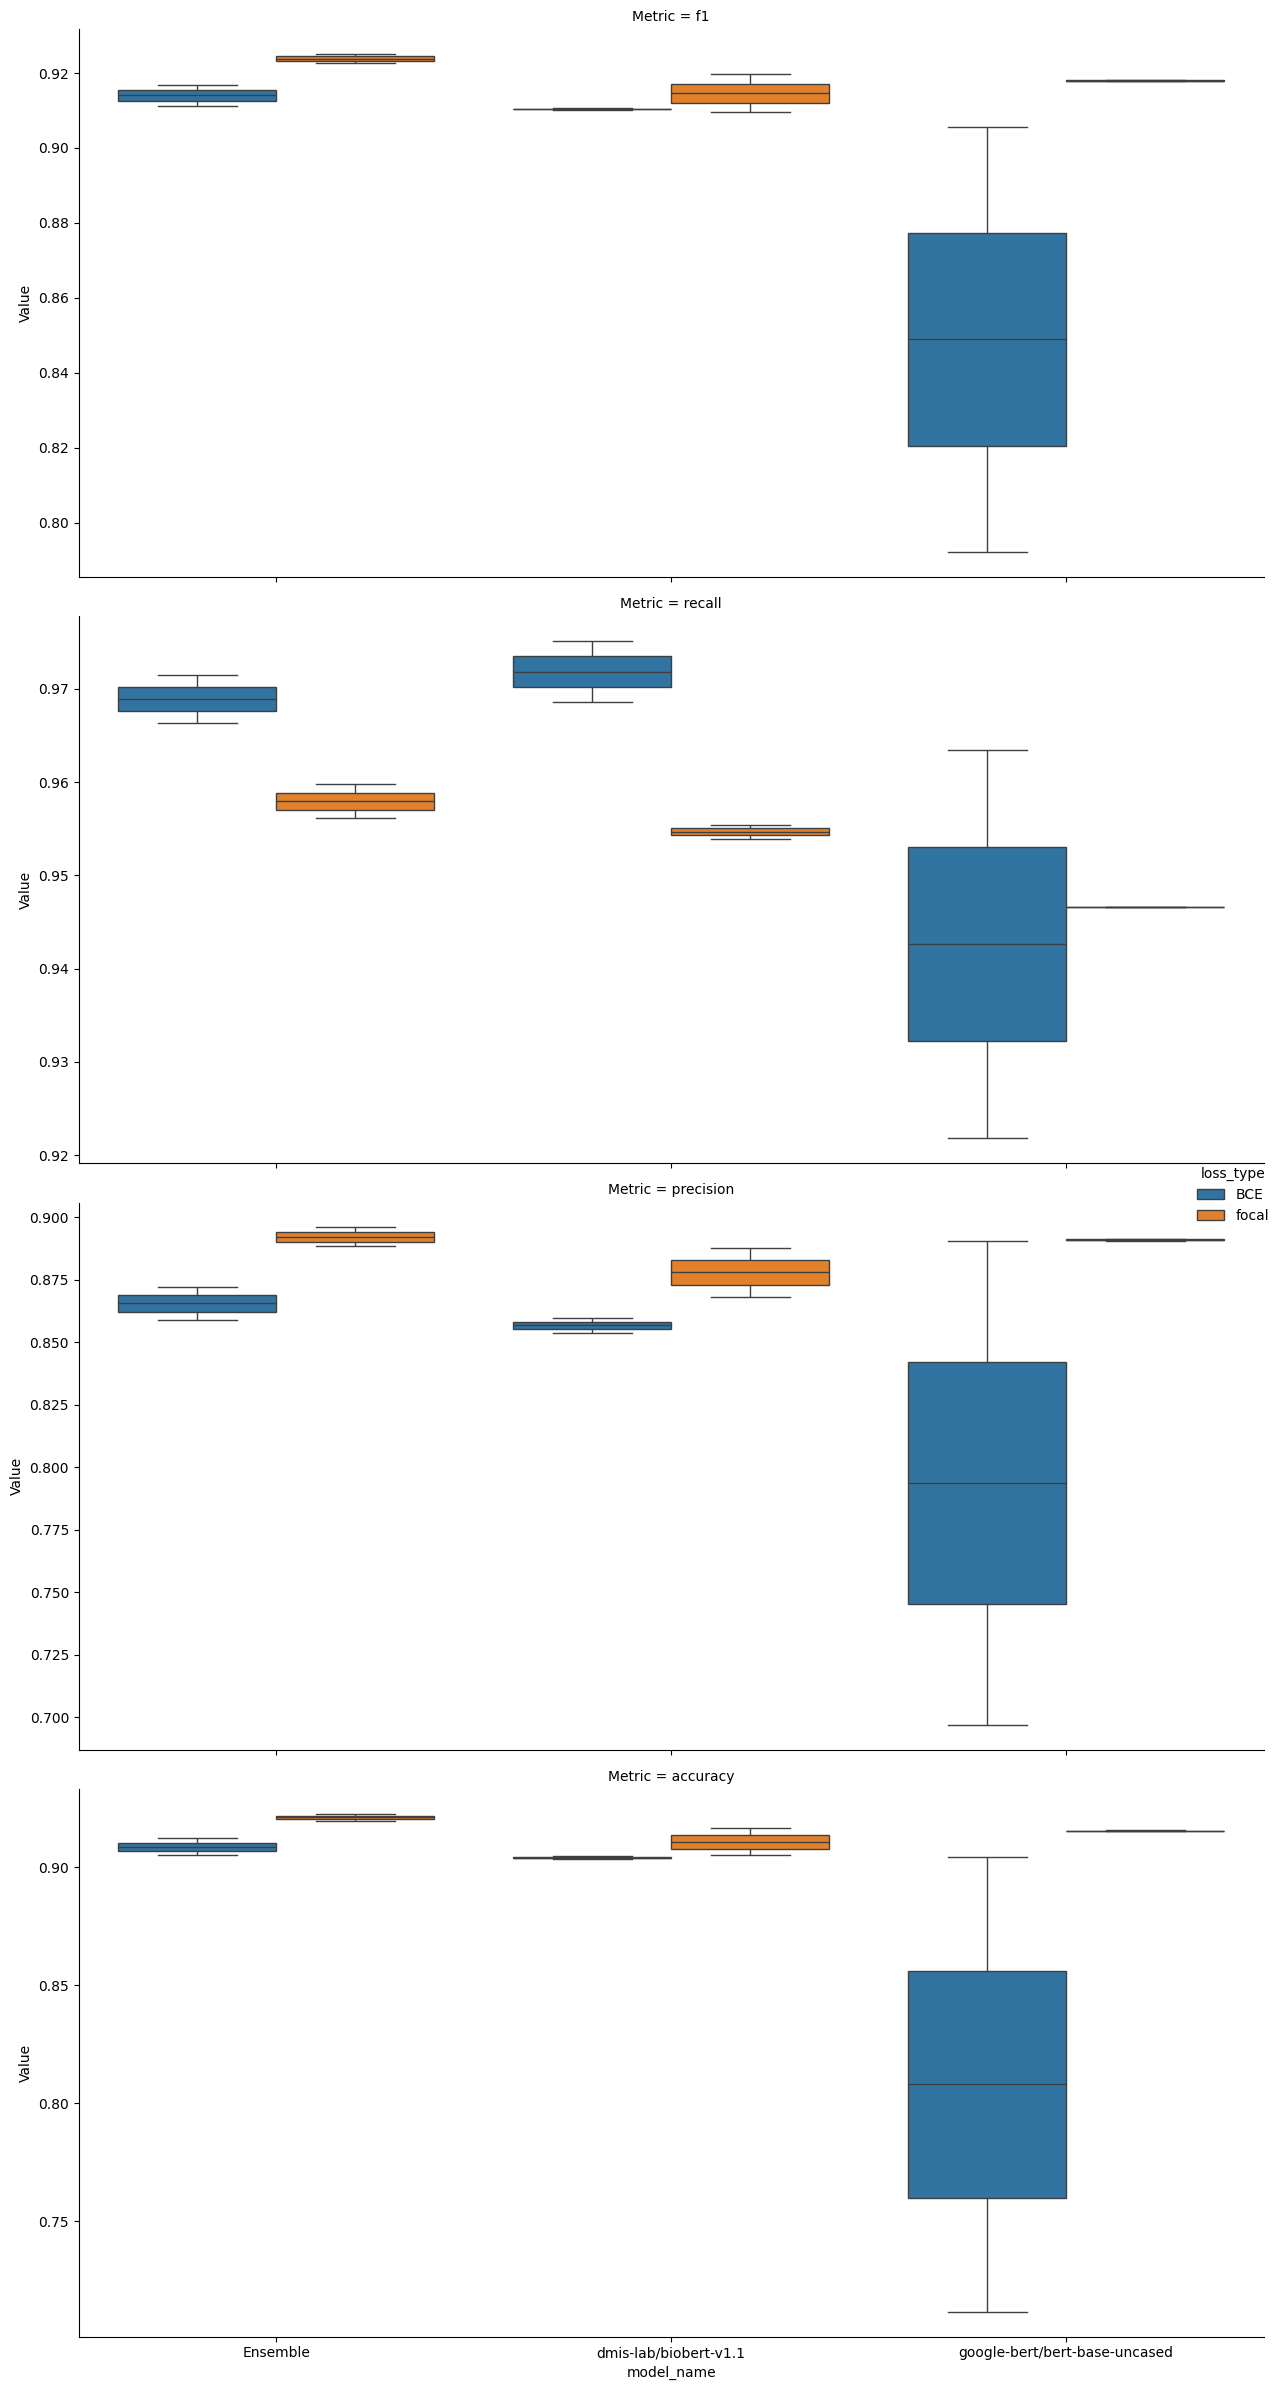

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_models_actual_perfs(df,loss_type,classification_type,comp_loss=False, plot_name="models_metrics_comp"):
    #TODO : Compare perfs with a baseline pre-trained model and an SVM (add functions for this)
    """
    Plots metrics distribution across runs for the last configuration/training.
    """
    # Group by relevant columns and calculate mean metrics
    avg_metrics = df.groupby(
        ["data_type", "loss_type", "model_name", "run"]
    )[["f1", "recall", "precision", "accuracy"]].mean().reset_index()

    # Filter metrics for the current data_type and loss_type
    filtered_metrics = avg_metrics[
        (avg_metrics["data_type"] == classification_type)
    ]

    # Create a boxplot for each metric
    melted_metrics = filtered_metrics.melt(
        id_vars=["loss_type","model_name"], 
        value_vars=["f1", "recall", "precision", "accuracy"],
        var_name="Metric", 
        value_name="Value"
    )
    
    if comp_loss!=True:
        sns.catplot(
            data=melted_metrics, 
            x="model_name", 
            y="Value",
            row="Metric",
            kind="box", 
            height=6, 
            aspect=2,
            sharey=False
        )
    else :
        sns.catplot(
            data=melted_metrics, 
            x="model_name", 
            y="Value",
            row="Metric",
            hue="loss_type", 
            kind="box", 
            height=6, 
            aspect=2,
            sharey=False
        )
    plt.tight_layout()
    plt.show()

metrics_df = pd.read_csv("/home/leandre/Projects/BioMoQA_Playground/metrics.csv")

plot_models_actual_perfs(metrics_df,"focal","SUA",comp_loss=True)
